In [1]:
!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn pillow opencv-python kagglehub


Dataset Download

In [4]:
import os

# Set Kaggle API environment variable
os.environ["KAGGLE_CONFIG_DIR"] = "/path/to/kaggle.json"

# Download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /desired/path

# Unzip the dataset
!unzip /desired/path/chest-xray-pneumonia.zip -d /desired/path


Streaming output truncated to the last 5000 lines.
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /desired/path/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
 

In [5]:
import os

dataset_path = "/desired/path/chest_xray"  # Adjust to your dataset location
print("Dataset contents:", os.listdir(dataset_path))


Dataset contents: ['train', 'chest_xray', 'test', 'val', '__MACOSX']


 Data Preprocessing

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define dataset paths
dataset_path = '/desired/path/chest_xray'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

# Create ImageDataGenerators
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Non-augmented train generator
train_generator = data_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Subset for training
)

# Non-augmented validation generator
validation_generator = data_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Subset for validation
)

# Non-augmented test generator
test_generator = data_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


 Data Augmentation

In [20]:
# Create an augmented data generator
data_gen_augmented = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zooms
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in missing pixels after transformations
    validation_split=0.2  # Splitting validation data from augmented data
)

# Augmented train generator
train_augmented_generator = data_gen_augmented.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Subset for training
)

# Augmented validation generator
validation_augmented_generator = data_gen_augmented.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Subset for validation
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


Model development

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 model (without the top layer for fine-tuning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


Train Model

In [22]:
# Train on Non-Augmented Data
history_non_augmented = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Train on Augmented Data
history_augmented = model.fit(
    train_augmented_generator,
    validation_data=validation_augmented_generator,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.8678 - loss: 0.2847 - val_accuracy: 0.9693 - val_loss: 0.1001
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9491 - loss: 0.1164 - val_accuracy: 0.9741 - val_loss: 0.0854
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9683 - loss: 0.0896 - val_accuracy: 0.9712 - val_loss: 0.0908
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9716 - loss: 0.0826 - val_accuracy: 0.9751 - val_loss: 0.0807
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.9722 - loss: 0.0677 - val_accuracy: 0.9741 - val_loss: 0.0772
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.9799 - loss: 0.0584 - val_accuracy: 0.9770 - val_loss: 0.0708
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9790 - loss: 0.0615 - val_accuracy: 0.9751 - val_loss: 0.0703
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9841 - loss: 0.0488 - val_accuracy: 0.978

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.8893 - loss: 0.2923 - val_accuracy: 0.9252 - val_loss: 0.1736
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9167 - loss: 0.1976 - val_accuracy: 0.9358 - val_loss: 0.1479
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.9373 - loss: 0.1644 - val_accuracy: 0.9243 - val_loss: 0.1583
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9271 - loss: 0.1755 - val_accuracy: 0.9329 - val_loss: 0.1617
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.9477 - loss: 0.1546 - val_accuracy: 0.9415 - val_loss: 0.1424
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.9403 - loss: 0.1488 - val_accuracy: 0.9300 - val_loss: 0.1569
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9360 - loss: 0.1570 - val_accuracy: 0.9367 - val_loss: 0.1456
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.9473 - loss: 0.1420 - val_accuracy: 0.939

Evaluation

In [23]:
from sklearn.metrics import confusion_matrix, roc_auc_score

# Make predictions on the test set
test_predictions = model.predict(test_generator, batch_size=32)
test_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(test_labels, test_predictions.round())

# Sensitivity (Recall) and Specificity
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# ROC-AUC Score
roc_auc = roc_auc_score(test_labels, test_predictions)

# Display results
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"ROC-AUC Score: {roc_auc}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Sensitivity: 0.6512820512820513
Specificity: 0.29914529914529914
ROC-AUC Score: 0.47471509971509973


Comparison of Augmented vs Non-Augmentad Result

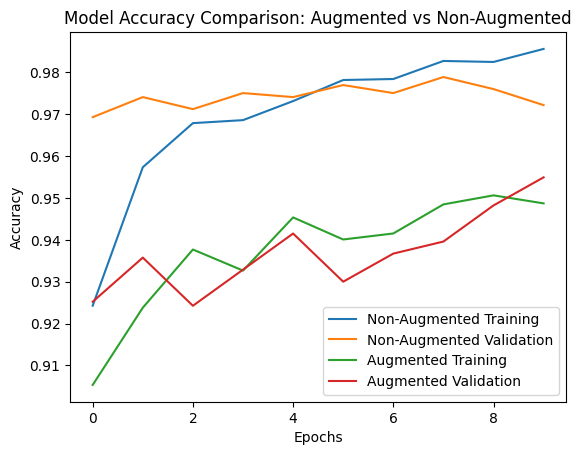

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for non-augmented and augmented datasets
plt.plot(history_non_augmented.history['accuracy'], label='Non-Augmented Training')
plt.plot(history_non_augmented.history['val_accuracy'], label='Non-Augmented Validation')
plt.plot(history_augmented.history['accuracy'], label='Augmented Training')
plt.plot(history_augmented.history['val_accuracy'], label='Augmented Validation')

# Adding title and labels to the plot
plt.title('Model Accuracy Comparison: Augmented vs Non-Augmented')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Show legend to differentiate between the datasets
plt.legend()

# Display the plot
plt.show()


Save Result

In [25]:
model.save("pneumonia_detection_model.h5")
print("Model saved as pneumonia_detection_model.h5")


Model saved as pneumonia_detection_model.h5
